Supervised learning techniques, like the Random Forest algorithm, offer a robust framework for classifying complex landscapes, such as distinguishing between riparian and grassland areas within a watershed. This method relies on manually selected and labeled training areas to teach the model how to recognize these distinct environments.  This tutorial focuses on using satellite imagery and Random Forest classification in Google Earth Engine (GEE) to accurately identify and classify riparian versus grassland regions in a watershed.

In [76]:
# Import modules and initialize
import ee
import json
import folium
import numpy as np
from pprint import pprint
from matplotlib import colormaps, colors
import requests
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# Authenticate
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

## Define helper functions

In [89]:
# Create helper functions

# Get Color for different polygons
def get_polygon_color(polygon):
    color_values = ['#7b3294', '#008837']
    color = color_values[polygon['properties']['label']]
    return {'fillColor':color, 'fillOpacity':0.8}
    
    
def maskS2clouds(image):
    """
    Function to filter images by cloud percentage
    """
    qa = image.select('QA60')
    cloudBitMask = 1 << 10 # bits 10
    cirrusBitMask = 1 << 11 # bits 11

    # Both flags should be set to zero (clear sky conditions)
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask)


# Define auxiliary functions
def create_raster(ee_object, vis_params, name):
    """
    Function that createst GEE map into raster for folium map
    """
    raster = folium.raster_layers.TileLayer(ee_object.getMapId(vis_params)['tile_fetcher'].url_format,
                       name=name,
                       overlay=True,
                       control=True,
                       attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>')
    return raster


## Load region boundaries

In [4]:
# Import boundary for region of interest (roi)
with open('../datasets/kings_creek.geojson') as file:
    roi_json = json.load(file)

# Define the ee.Geometry
roi_geom = ee.Geometry(roi_json['features'][0]['geometry'])


## Load labeled regions for training

These polygons were created manually by inspecting a satellite image and drawing over small portions of the watershed that were clearly with riparian and grassland vegetation. Here is an excellent tool to get you started: [https://geojson.io](https://geojson.io)

In [5]:
# Import labeled regions for riparian and grassland areas.
with open('../datasets/riparian.geojson') as file:
    riparian_json = json.load(file)

with open('../datasets/grassland.geojson') as file:
    grassland_json = json.load(file)

    
# Define the ee.Geometry for each polygon
riparian_geom = ee.Feature(riparian_json['features'][0]['geometry'])
grassland_geom = ee.Feature(grassland_json['features'][0]['geometry'])


In [6]:
# Add class values to features
riparian_geom = riparian_geom.set('land_cover', 0)
grassland_geom = grassland_geom.set('land_cover', 1)


In [7]:
# Merge train dataset into a FeatureCollection
training_regions = ee.FeatureCollection([riparian_geom, grassland_geom])


## Load image dataset

This image will be used to detect riparian and grassland vegetation beyond the provided training regions.

In [8]:
# Sentinel 2 multispectral instrument
S2 = ee.ImageCollection('COPERNICUS/S2_SR').filterDate('2022-06-01', '2022-07-31')
S2 = S2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)).map(maskS2clouds)

# Mean multispectral image for entire period
img = S2.mean().divide(10000).clip(roi_geom)


In [9]:
# Select values from dataset for the training regions 
training_data = img.sampleRegions(collection=training_regions,
                                  properties=['land_cover'], scale=30)

In [10]:
# Train Random Forest algorithm
ntrees = 10
trained_classifier = ee.Classifier.smileRandomForest(ntrees).train(features=training_data,
                                                       classProperty='land_cover',
                                                       inputProperties=img.bandNames())

In [11]:
# Classify the entire King's Creek Watershed
classified_img = img.classify(trained_classifier)
classified_vector = classified_img.reduceToVectors(scale=30, 
                                                   geometry=roi_geom).getInfo()

## Save static maps

Download vector and raster maps.

In [52]:
# Save vector map to GeoJSON file
filename_classified_vector = '../outputs/classified_vector_kings_creek.tif'
with open(filename_classified_vector, 'w') as file:
    # Convert dictionary to a GeoJSON string and save it
    file.write(json.dumps(classified_vector))
    
    
# Create raster of classified image in geoTIFF image
classified_img_url = classified_img.getDownloadUrl({
    'region': roi_geom,
    'scale':30,
    'crs': 'EPSG:4326',
    'format': 'GEO_TIFF'
})

# Request and save geoTIFF map
response = requests.get(classified_img_url)
filename_classified_img = '../outputs/classified_kings_creek.tif'
with open(filename_classified_img, 'wb') as f:
    f.write(response.content)

# Create raster of classified image in geoTIFF image
truecolor_img_url = img.getDownloadUrl({
    'region': roi_geom,
    'scale':30,
    'crs': 'EPSG:4326',
    'format': 'GEO_TIFF',
    'bands':['B4', 'B3', 'B2']
})

# Request and save geoTIFF map
response = requests.get(truecolor_img_url)
filename_truecolor_img = '../outputs/truecolor_kings_creek.tif'
with open(filename_truecolor_img, 'wb') as f:
    f.write(response.content)

## Create static figure

In [78]:
# Read GeoTiff file using the Xarray package
raster_classified = xr.open_dataarray(filename_classified_img).squeeze() # 2d image
raster_truecolor = xr.open_dataarray(filename_truecolor_img)

# COnvert vector layer to GeoDataframe
gdf = gpd.GeoDataFrame.from_features(classified_vector['features'], crs=4326)
gdf.head(3)


,geometry,count,label
0,"POLYGON ((-96.55425 39.09019, -96.55344 39.090...",3,0
1,"POLYGON ((-96.55398 39.08776, -96.55398 39.087...",77,0
2,"POLYGON ((-96.55452 39.08965, -96.55452 39.089...",5,0


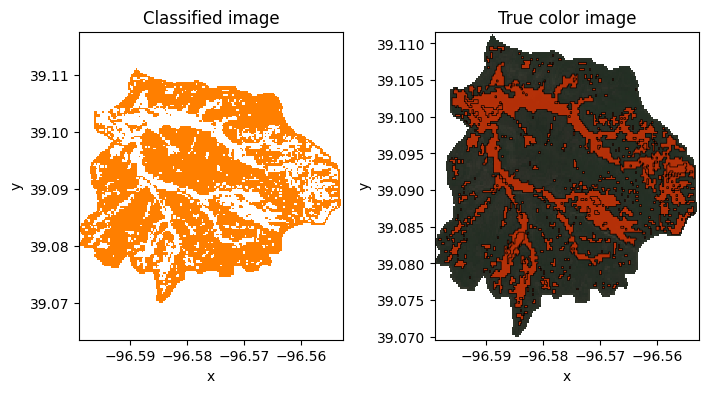

In [106]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
fig.subplots_adjust(wspace=0.35)

raster_classified.plot.imshow(ax=ax1, cmap='Set1', add_colorbar=False);
ax1.set_title('Classified image')
ax1.axis('equal')

raster_truecolor.plot.imshow(ax=ax2);
ax2.set_title('True color image')
ax2.axis('equal')

idx_riparian = gdf['label'] == 0 # select rows for riparian areas
gdf.loc[idx_riparian].plot(ax=ax2, facecolor=(0.9,0.2,0,0.75), 
                           edgecolor='k', linewidth=0.5)


plt.show()

## Interactive map

In [90]:
# Create Folium Map
m = folium.Map(location=[39.09, -96.592], zoom_start=13)

# Create vector layer of classified polygons
cluster_layer = folium.GeoJson(classified_vector, 
                             name="Classified image with RF",
                             style_function=get_polygon_color)


# Visualization parameters of true color image
# B4=Red, B3=Green, B2=Blue
vis_params = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2'], }


# Create raster layer of true color image
true_color_layer = folium.raster_layers.TileLayer(img.getMapId(vis_params)['tile_fetcher'].url_format,
                       name='True color',
                       overlay=True,
                       control=True,
                       attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>')

# Add layers to interactive map
true_color_layer.add_to(m)
cluster_layer.add_to(m)

# Add map controls to be able to compare 
# the true color image with the clasified layer
folium.LayerControl().add_to(m)

# Render map
m
